In [14]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [15]:
data_file = np.load("test-fit.npz", allow_pickle=True)
e = data_file['eps']
f = data_file['fe']

In [16]:
data_file2 = np.load("test-fit2.npz", allow_pickle=True)
e2 = data_file2['eps']
f2 = data_file2['fe']

In [31]:
@nb.jit(nopython=True)
def fit2(e_array, f_array):
    e_max = e_array[np.where(e_array**2*f_array == np.max(e_array**2*f_array))[0]][0]
    f_max = f_array[np.where(e_array**2*f_array == np.max(e_array**2*f_array))[0]][0]
    
    Del_e = e_array[1] - e_array[0]
    Del_T = (1/2.301)*Del_e
    
    T = e_max/2.301
    N = (((np.exp(e_max/T)+1)*np.max(e_array**2*f_array))/e_max**2)
    Del_N = (((np.exp(e_max/T+Del_T)+1)*np.max(e_array**2*f_array))/e_max**2)
    
    return T,N,Del_T,Del_N

In [32]:
@nb.jit(nopython=True)
def least_sum(e_array,f_array,T, N):
    Sum = 0 
    for i in range(len(e_array)):
        Sum = Sum + ((e_array[i]**2*f_array[i]-((N)*(e_array[i]**2)/(np.exp(e_array[i]/T)+1)))**2)
    return Sum

In [33]:
@nb.jit(nopython=True)
def fit3(e_array,f_array):
    
    T_0, N_0, T_error, N_error = fit2(e_array,f_array)
    
    
    T = np.linspace(T_0-T_error,T_0+T_error,100)
    N = np.linspace(N_0-N_error,N_0+N_error,100)
    M = np.zeros((len(T),len(N)))
    for i in range(len(T)):
        for j in range(len(N)):
            M[i,j] = least_sum(e_array,f_array,T[i],N[j])
    
    w = np.where(M==np.amin(M))
    T_best = T[w[0][0]]
    N_best = N[w[1][0]]
    
    return T_best,N_best

In [40]:
def everything1(e_array,f_array):
    Tbest,Nbest = fit3(e_array,f_array)
    e_array_reverse = e_array[::-1]
    f_array_reverse = f_array[::-1]
    diff_reverse = np.zeros(len(e_array_reverse))
    
    for i in range(len(e_array_reverse)):
        diff_reverse[i] = (f_array_reverse[i])-((Nbest)/(np.exp(e_array_reverse[i]/Tbest)+1))
    return diff_reverse,Tbest,Nbest

In [43]:
def everything2(e_array,f_array):
    diff_still_reverse,T_best,N_best = everything1(e_array,f_array)
    
    diff_smaller_reverse = []
    for i in diff_still_reverse: 
        if i < 0:
            break
        if i > 0:
            diff_smaller_reverse.append(i)
    diff_smaller_correct = diff_smaller_reverse[::-1]
    E_new = e_array[len(e_array)-len(diff_smaller_correct):]
    F_new = f_array[len(e_array)-len(diff_smaller_correct):]
    
    
    np.polyfit(E_new,np.log(diff_smaller_correct),2) 
    A_best = np.polyfit(E_new,np.log(diff_smaller_correct),2)[0]
    B_best = np.polyfit(E_new,np.log(diff_smaller_correct),2)[1]
    C_best = np.polyfit(E_new,np.log(diff_smaller_correct),2)[2]
    
    poly = A_best*e_array**2+B_best*e_array+C_best
    
    
    plt.figure()
    plt.semilogy(e_array,e_array**2*f_array,color="black")
    plt.semilogy(e_array,N_best*(e_array**2)/(np.exp(e_array/T_best)+1)+e**2*np.exp(poly),color="green")
    plt.show()
    
    return A_best,B_best,C_best,T_best,N_best
    

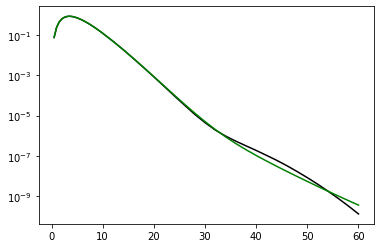

(0.0012908544032027547,
 -0.4484654379921326,
 -7.659854919569376,
 1.5671710586964824,
 0.7117404676647079)

In [44]:
everything2(e,f)

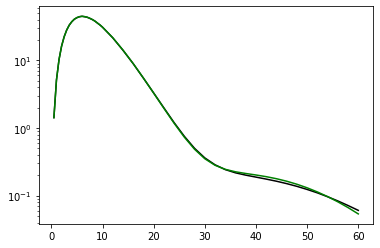

(-0.002040106185677538,
 0.09924849888416934,
 -9.722659061181984,
 2.7195027195027195,
 12.570015639330949)

In [45]:
everything2(e2,f2)